In [3]:
import pandas as pd
from simpledbf import Dbf5
from scipy.stats import variation
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR

PyTables is not installed. No support for HDF output.


In [7]:
def load_data(first_path, second_path):
    dbf1 = Dbf5(first_path)
    dbf2 = Dbf5(second_path)
    df_ndvi_lst = dbf1.to_dataframe()
    df_ndvi_ndvi = dbf2.to_dataframe()
    df_ndvi_ndvi = df_ndvi_ndvi[['grid_code', 'FID_pixelc']]
    return df_ndvi_lst, df_ndvi_ndvi
    
dbf1 = Dbf5('ndvi_lst_data.dbf')
dbf2 = Dbf5('ndvi_ndvi_data.dbf')
df_ndvi_lst, df_ndvi_ndvi = load_data('ndvi_lst_data.dbf', 'ndvi_ndvi_data.dbf')

In [8]:
df_ndvi_lst[df_ndvi_lst['FID_pixelc'] == 306]

,OBJECTID,FID_Raster,FID_Rast_1,pointid,grid_code,FID_Rast_2,pointid_1,grid_code_,FID_pixelc,Id
13,14,14,9215,9215,1412,9215,9215,14837,306,0


In [118]:
def get_data_groups(dataframe, data_groups_explaination, column):
    data_groups = {}
    for data_group in data_groups_explaination:
        if data_group['from'] == 0:
            data_groups[data_group['name']] = dataframe[dataframe[column] < data_group['to']]
            continue
        if data_group['to'] == 0:
            data_groups[data_group['name']] = dataframe[dataframe[column] >= data_group['from']]
            continue
        group = dataframe[dataframe[column] < data_group['to']]
        group = group[group[column] >= data_group['from']]
        data_groups[data_group['name']] = group
    return data_groups

In [103]:
def is_valid(group):
    return len(group) > 0

In [104]:
def group(dataframe, by):
    df_1k_groups = []
    for id in range(min(dataframe[by]), max(dataframe[by]) + 1):
        group = dataframe[dataframe[by] == id]
        if is_valid(group):
            df_1k_groups.append(group)
    return df_1k_groups

In [105]:
# df_ndvi_ndvi.groupby(by='FID_pixelc')
df_ndvi_ndvi = df_ndvi_ndvi[['grid_code', 'FID_pixelc']]
df_ndvi_ndvi_grouped = df_ndvi_ndvi.groupby(by='FID_pixelc', axis=1)
len(df_ndvi_ndvi[df_ndvi_ndvi['FID_pixelc'] == 303])

df_ndvi_ndvi_groups = group(df_ndvi_ndvi, 'FID_pixelc')
df_ndvi_ndvi_groups

[        grid_code  FID_pixelc
 788645       1840         303
 788646       1579         303
 788647       1406         303
 788648       1460         303
 788702       1464         303
 ...           ...         ...
 788995       1435         303
 788996       1427         303
 788997       1392         303
 788998       1432         303
 788999       1463         303
 
 [90 rows x 2 columns],
         grid_code  FID_pixelc
 788339       2575         304
 788362       2575         304
 788363       2594         304
 788364       2529         304
 788365       2594         304
 ...           ...         ...
 789026       2720         304
 789027       2640         304
 789028       2363         304
 789029       2502         304
 789030       2535         304
 
 [316 rows x 2 columns],
         grid_code  FID_pixelc
 788286       1763         305
 788287       1646         305
 788288       1927         305
 788289       1650         305
 788290       1531         305
 ...           ..

In [106]:
max(df_ndvi_ndvi_groups[1]['FID_pixelc'])

304

In [107]:
def get_coef_variation(dataframe_groups, column, id_column='FID_pixelc'):
    coefs = []
    field_id_array = []
    for group in dataframe_groups:
        coef_variation = variation(group[column])
        coefs.append(coef_variation)
        field_id_array.append(max(group[id_column]))
    return pd.DataFrame({id_column: field_id_array, 'coef_variation': coefs})

In [108]:
df = get_coef_variation(df_ndvi_ndvi_groups, 'grid_code')
df

,FID_pixelc,coef_variation
0,303,0.497010
1,304,0.158122
2,305,0.329401
3,410,0.087801
4,411,0.489288
...,...,...
1322,5627,0.635502
1323,5732,0.157028
1324,5733,0.116603
1325,5734,0.272233


In [109]:
def get_chosen_dataframe_including_ids(dataframe, ids, column='FID_pixelc'):
    drop_ids = []
    chosen_dataframe = pd.DataFrame()
    empty_rows = 0
    for i in ids:
        row = dataframe[dataframe[column] == i]
        if len(row) == 0:
            empty_rows += 1
            drop_ids.append(i)
        chosen_dataframe = chosen_dataframe.append(row)
    return chosen_dataframe, empty_rows, drop_ids


def drop_unmatched_rows(df, drop_ids):
    for id in drop_ids:
        df['FID_pixelc'].replace(id, np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    

In [110]:
def get_ndvi_lst_variation_df():
    # load bot data for ndvi ndvi and for ndvi lst
    df_ndvi_lst, df_ndvi_ndvi = load_data('ndvi_lst_data.dbf', 'ndvi_ndvi_data.dbf')
    
    # group ndvi 30m by their 1km squared parent pixel 
    df_ndvi_ndvi_groups = group(df_ndvi_ndvi, 'FID_pixelc')
    
    # calculate the coef of vaiation for the groups
    df = get_coef_variation(df_ndvi_ndvi_groups, 'grid_code')
    
    # get the chosen data from the dataframe using the ids
    df_ndvi_lst_clipped, empty, drop_ids = get_chosen_dataframe_including_ids(df_ndvi_lst, df['FID_pixelc'])
    
    # reset the index so we can compare them to each other
    df.reset_index(inplace=True)
    
    # sort the tables to make sure that they are in the same order
    
    df_ndvi_lst_clipped.sort_values(by=['FID_pixelc'], inplace=True)
    df.sort_values(by=['FID_pixelc'], inplace=True)
    df_ndvi_lst_clipped.reset_index(inplace=True)

    drop_unmatched_rows(df, drop_ids)

    df_ndvi_lst_clipped['coef_variation'] = df['coef_variation']
    
    return df_ndvi_lst_clipped
    

In [114]:
# df_ndvi_lst_clipped, empty, drop_ids = get_dataframe_including_ids(df_ndvi_lst, df['FID_pixelc'])
# df.reset_index(inplace=True)
# df_ndvi_lst_clipped.reset_index(inplace=True)
# df_ndvi_lst_clipped.sort_values(by=['FID_pixelc'], inplace=True)
# df.sort_values(by=['FID_pixelc'], inplace=True)

get_ndvi_lst_variation_df()

,index,OBJECTID,FID_Raster,FID_Rast_1,pointid,grid_code,FID_Rast_2,pointid_1,grid_code_,FID_pixelc,Id,coef_variation
0,12,13,13,9214,9214,2641,9214,9214,14842,305,0,0.329401
1,25,26,26,9197,9197,1838,9197,9197,14823,413,0,0.266128
2,26,27,27,9198,9198,1957,9198,9198,14824,414,0,0.457241
3,27,28,28,9199,9199,1739,9199,9199,14827,415,0,0.439574
4,28,29,29,9200,9200,4329,9200,9200,14828,416,0,0.386035
...,...,...,...,...,...,...,...,...,...,...,...,...
1301,3857,3858,3858,5326,5326,2062,5326,5326,14679,5627,0,0.635502
1302,3946,3947,3947,5222,5222,1160,5222,5222,14712,5732,0,0.157028
1303,3947,3948,3948,5223,5223,1788,5223,5223,14688,5733,0,0.116603
1304,3948,3949,3949,5224,5224,3202,5224,5224,14685,5734,0,0.272233


In [112]:
df_ndvi_lst_variation = get_ndvi_lst_variation_df()

In [122]:
data_groups_explaination=[{'name': 'group1', 'from': 0, 'to': 2000}, 
                          {'name': 'group2', 'from': 2000, 'to': 5000}, 
                          {'name':'group3', 'from': 5000, 'to': 0}]
df_groups = get_data_groups(df_ndvi_lst_variation, data_groups_explaination, 'grid_code')

In [86]:
df_ndvi_lst_variation.isna().sum()

index             0
OBJECTID          0
FID_Raster        0
FID_Rast_1        0
pointid           0
grid_code         0
FID_Rast_2        0
pointid_1         0
grid_code_        0
FID_pixelc        0
Id                0
coef_variation    0
dtype: int64

In [87]:
group_populations

{'group1': 344, 'group2': 973, 'group3': 333}

In [137]:
def compute_first_percentage_of_groups(df_groups, percentage=0.25):
    group_populations = {name: len(df_groups[name]['grid_code']) for name in df_groups}
    for group in df_groups:
        df_groups[group].sort_values(by=['coef_variation'], inplace=True)
        first_25_percent = int(group_populations[group] * percentage)
        df_groups[group] = df_groups[group][:first_25_percent]

In [138]:
compute_first_percentage_of_groups(df_groups, 0.25)

min(df_groups['group2']['grid_code'])

<ipython-input-137-577934942161>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_groups[group].sort_values(by=['coef_variation'], inplace=True)


2013

In [139]:
def get_cleaned_data(data_groups_explaination):
    df_groups = get_data_groups(df_ndvi_lst_variation, data_groups_explaination, 'grid_code')
    compute_first_percentage_of_groups(df_groups, 0.25)
    cleaned_data = pd.DataFrame()
    for group in df_groups:
        cleaned_data = cleaned_data.append(df_groups[group])
    return cleaned_data

<ipython-input-137-577934942161>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_groups[group].sort_values(by=['coef_variation'], inplace=True)


,index,OBJECTID,FID_Raster,FID_Rast_1,pointid,grid_code,FID_Rast_2,pointid_1,grid_code_,FID_pixelc,Id,coef_variation
877,2501,2502,2502,6688,6688,1423,6688,6688,14745,4059,0,0.000000
104,218,219,219,9026,9026,1270,9026,9026,14833,1084,0,0.027547
483,1177,1178,1178,8098,8098,1409,8098,8098,14811,2531,0,0.030835
980,2790,2791,2791,6394,6394,1675,6394,6394,14721,4393,0,0.037548
1305,3949,3950,3950,5225,5225,1613,5225,5225,14677,5735,0,0.045487
...,...,...,...,...,...,...,...,...,...,...,...,...
377,875,876,876,8362,8362,7300,8362,8362,14746,2180,0,0.329128
925,2612,2613,2613,6604,6604,5108,6604,6604,14689,4185,0,0.330099
1111,3102,3103,3103,6122,6122,5639,6122,6122,14726,4750,0,0.331053
1043,2914,2915,2915,6324,6324,5253,6324,6324,14752,4532,0,0.331692


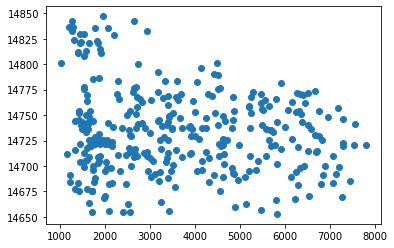

In [140]:


plt.scatter(cleaned_data['grid_code'], cleaned_data['grid_code_'])

<AxesSubplot:xlabel='grid_code', ylabel='grid_code_'>

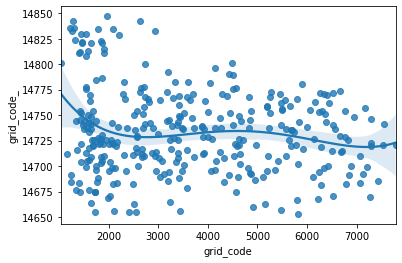

In [141]:
sns.regplot(x='grid_code', y='grid_code_', data=cleaned_data, order=4)

In [23]:
#sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, train_size=0.8)

In [24]:
lr_linear = LR()
X_train = train_data[['grid_code']]
y_train = train_data['grid_code_']
lr_linear.fit(X_train, y_train)

LinearRegression()

In [25]:
X_test = test_data[['grid_code']]
y_test = test_data['grid_code_']
lr_linear.predict(X_test)

array([14725.28439539, 14725.58525154, 14727.96156987, 14726.65573969,
       14725.00580132, 14725.77670545, 14726.91143561, 14724.99816861,
       14725.29902476, 14725.33591621, 14725.33209985, 14726.11000063,
       14728.31776319, 14727.37766724, 14725.21633702, 14725.34100469,
       14726.53425233, 14725.29902476, 14727.56848509, 14727.24981927,
       14725.28312327, 14726.3052709 , 14725.18135375, 14725.25004818,
       14724.93965113, 14728.37500855, 14725.10693479, 14726.02540472,
       14725.53818313, 14725.21697308, 14726.35170325, 14727.56212449,
       14727.59774383, 14725.08403664, 14725.55090432, 14727.02210997,
       14727.23773414, 14728.86286619, 14727.93167507, 14726.54061292,
       14725.23478275, 14725.25450059, 14726.23975677, 14726.90443896,
       14727.34395608, 14725.9471694 , 14726.82111516, 14727.48579735,
       14725.74426641, 14727.32678247, 14726.4153092 , 14725.27994297,
       14727.66389401, 14725.09930207, 14726.59785828, 14726.0979155 ,
      

In [26]:
lr_linear2  = LR()
lr_linear2.fit(cleaned_data[['grid_code']], cleaned_data['grid_code_'])
lr_linear.score(cleaned_data[['grid_code']], cleaned_data['grid_code_']) * 100

-0.013502906894125033

In [27]:
test_data

,index,OBJECTID,FID_Raster,FID_Rast_1,pointid,grid_code,FID_Rast_2,pointid_1,grid_code_,FID_pixelc,Id,coef_variation
455,1149,1150,1150,8070,8070,1904,8070,8070,14727,2503,0,0.318249
1166,3277,3278,3278,5909,5909,2377,5909,5909,14654,4955,0,0.309198
1088,3019,3020,3020,6234,6234,6113,6234,6234,14765,4652,0,0.210994
1237,3480,3481,3481,5724,5724,4060,5724,5724,14695,5189,0,0.314249
1160,3211,3212,3212,6037,6037,1466,6037,6037,14788,4874,0,0.305481
...,...,...,...,...,...,...,...,...,...,...,...,...
787,2218,2219,2219,6990,6990,1625,6990,6990,14717,3732,0,0.210575
1303,3947,3948,3948,5223,5223,1788,5223,5223,14688,5733,0,0.186832
772,2137,2138,2138,7104,7104,1422,7104,7104,14759,3636,0,0.122309
6,42,43,43,9176,9176,5043,9176,9176,14804,521,0,0.266128


In [28]:
cleaned_data = cleaned_data[['grid_code', 'grid_code_', 'FID_pixelc', 'coef_variation']]
# cleaned_data.to_excel("cleaned_data.xlsx") 

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
degree=4
polyreg=make_pipeline(PolynomialFeatures(degree),LR())
polyreg.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

In [30]:
polyreg.score(X_train, y_train) * 100

3.071424589574878

In [31]:
scores = [] 
for i in range(1, 50):
    degree=i
    polyreg=make_pipeline(PolynomialFeatures(degree),LR())
    polyreg.fit(X_test, y_test)
    score = polyreg.score(X_train, y_train)
    scores.append(score)
    


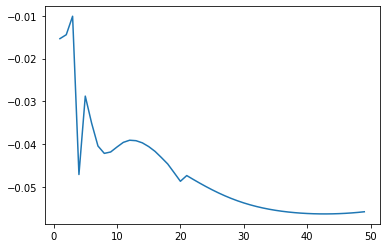

In [32]:
plt.plot(range(1, 50), scores)

In [33]:
degree=4
polyreg=make_pipeline(PolynomialFeatures(degree),LR())
polyreg.fit(X_test, y_test)
score = polyreg.score(X_train, y_train)
score

-0.047052630539098805

In [34]:
max(cleaned_data['grid_code_'])

14835

In [35]:
min(cleaned_data['grid_code_'])

14634

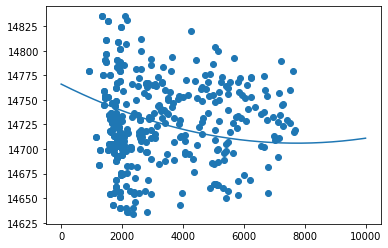

In [36]:
y_values = []
for x in range(0, 10000):
    y = -0.0155 * x + 14766 + 1* 10 ** -6 * x ** 2
    y_values.append(y)
    
x_values = list(range(10000))

plt.plot(x_values, y_values)
plt.scatter(cleaned_data['grid_code'], cleaned_data['grid_code_'])

In [39]:
cleaned_data.corr()

,grid_code,grid_code_,FID_pixelc,coef_variation
grid_code,1.000000,0.021096,-0.029060,-0.058881
grid_code_,0.021096,1.000000,-0.547109,-0.073978
FID_pixelc,-0.029060,-0.547109,1.000000,-0.102501
coef_variation,-0.058881,-0.073978,-0.102501,1.000000
